In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
# Load cleaned data
data = pd.read_csv('clean_encoded_train.csv', sep=';', decimal='.')

In [5]:
data.shape

(49867, 18)

In [ ]:
data.columns

In [ ]:
# 'WEBSITE', 'DEVICE', 'HAUL_TYPE', 'TRIP_TYPE' and 'PRODUCT' 
numeric_columns = ['TIMESTAMP', 'GDS', 'DEPARTURE', 'ARRIVAL', 'ADULTS',
                   'CHILDREN', 'INFANTS', 'DISTANCE','NO_GDS']
data[numeric_columns].describe()

In [ ]:
sns.countplot(x="WEBSITE", hue="EXTRA_BAGGAGE", data=data)

plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

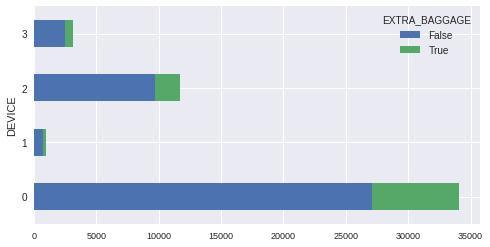

In [45]:
# sns.countplot(x="DEVICE", hue="EXTRA_BAGGAGE", data=data)

ct = pd.crosstab(data.DEVICE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

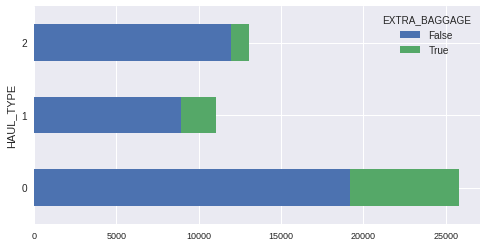

In [46]:
# sns.countplot(x="HAUL_TYPE", hue="EXTRA_BAGGAGE", data=data)

ct = pd.crosstab(data.HAUL_TYPE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

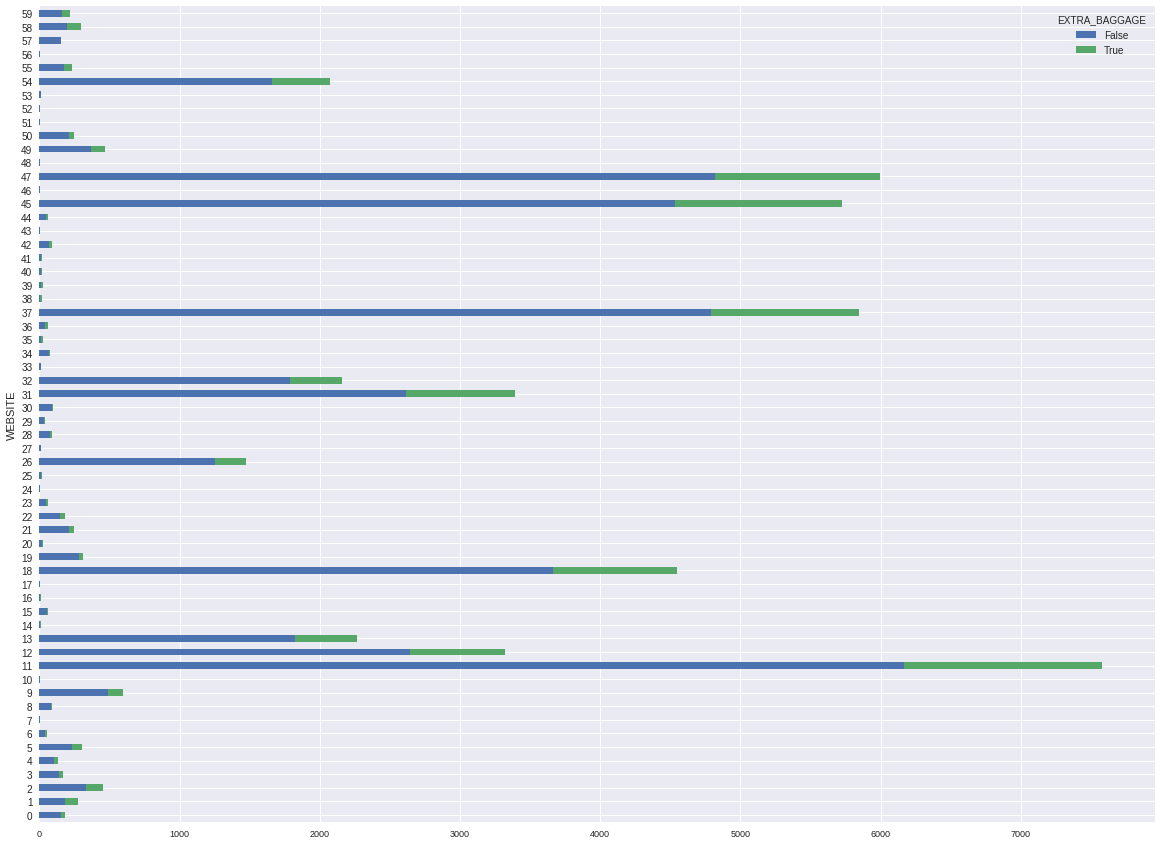

In [24]:
# sns.countplot(x="HAUL_TYPE", hue="EXTRA_BAGGAGE", data=data)

ct = pd.crosstab(data.WEBSITE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

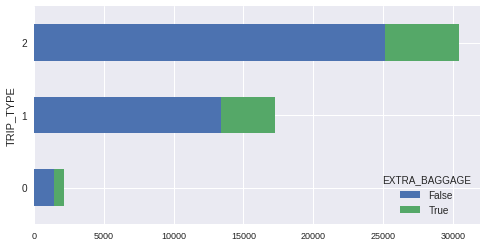

In [47]:
# sns.countplot(x="TRIP_TYPE", hue="EXTRA_BAGGAGE", data=data)

ct = pd.crosstab(data.TRIP_TYPE, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

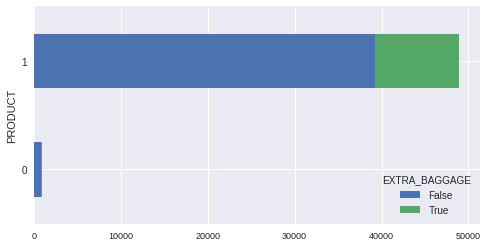

In [48]:
# sns.countplot(x="PRODUCT", hue="EXTRA_BAGGAGE", data=data)

ct = pd.crosstab(data.PRODUCT, data.EXTRA_BAGGAGE)

ct.plot.barh(stacked=True)
plt.legend(title='EXTRA_BAGGAGE')

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["xtick.labelsize"] = 9

plt.show()

plt.show()

In [ ]:
sns.distplot(data['DISTANCE'])

plt.show()

In [ ]:
sns.distplot(data['DISTANCE'][data['EXTRA_BAGGAGE'] == True])

plt.show()

In [ ]:
sns.distplot(data['DISTANCE'][data['EXTRA_BAGGAGE'] == False])

plt.show()

In [ ]:
sns.boxplot(x="EXTRA_BAGGAGE", y="DISTANCE", data=data)

plt.show()

In [3]:
# Load original data
original_data = pd.read_csv('train.csv', sep=';', decimal=',')

In [4]:
# We'll enrich the dataset with new variables that may contribute to increase the model's
# performance.

# We'll add a variable called 'TRIP_DAYS' that will be created using the 'DEPARTURE' and 
# 'ARRIVAL' variables. It will represent the duration in days of the trip.
def calculate_trip_days(row):
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < departure_date.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    trip_days = arrival_date - departure_date
    
    return trip_days.days

trip_days = original_data.apply(lambda row: calculate_trip_days(row), axis=1)
trip_days = trip_days[pd.notnull(original_data['DEVICE'])]
trip_days = trip_days.reset_index(drop=True)

data['TRIP_DAYS'] = trip_days

In [6]:
# We'll add a variable called 'PLANNING_DAYS' that will be created using the 'TIMESTAMP' and 
# 'DEPARTURE' variables. It will represent how many days ahead of the departure date, the trip
# was planned, starting from the day the plain tickets were bought.
def calculate_planning_days(row):
    buy_date = datetime.strptime(row['TIMESTAMP'] + "/2017", '%d/%B/%Y')
    departure_date = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    
    if departure_date.month < buy_date.month:
        departure_date = datetime.strptime(row['DEPARTURE'] + "/2018", '%d/%B/%Y')
    
    planning_days = departure_date - buy_date
    
    return planning_days.days

planning_days = original_data.apply(lambda row: calculate_planning_days(row), axis=1)
planning_days = planning_days[pd.notnull(original_data['DEVICE'])]
planning_days = planning_days.reset_index(drop=True)

data['PLANNING_DAYS'] = planning_days

In [7]:
# We'll add a variable called 'WEEKEND_DAYS' that will be created using the 'DEPARTURE' and 
# 'ARRIVAL' variables. It will represent how many wekkend days are included in the duration
# of the trip.
def calculate_weekend_days(row):
    aux = datetime.strptime(row['DEPARTURE'] + "/2017", '%d/%B/%Y')
    arrival_date = datetime.strptime(row['ARRIVAL'] + "/2017", '%d/%B/%Y')
    
    if arrival_date.month < aux.month:
        arrival_date = datetime.strptime(row['ARRIVAL'] + "/2018", '%d/%B/%Y')
    
    weekend_days = 0
    
    while (aux <= arrival_date):
        if (aux.weekday() > 4):
            weekend_days += 1
            
        aux = aux + timedelta(days=1)
    
    return weekend_days

weekend_days = original_data.apply(lambda row: calculate_weekend_days(row), axis=1)
weekend_days = weekend_days[pd.notnull(original_data['DEVICE'])]
weekend_days = weekend_days.reset_index(drop=True)

data['WEEKEND_DAYS'] = weekend_days

In [8]:
# Regional - anything less than an hour.
# Short Haul - 1 hour up to 3 or 4 hours.
# Medium Haul - 4 up to 6 or 7 hours.
# Long Haul - 7 to about 14 or 15 hours.
# Ultra Long Haul - anything over 15 hours non stop. 
def flight_duration(duration):
    if duration < 1:
        return 0 # REGIONAL
    elif duration >= 1 and duration < 4:
        return 1 # SHORT
    elif duration >= 4 and duration < 7:
        return 2 # MEDIUM
    elif duration >= 7 and duration < 15:
        return 3 # LONG
    else:
        return 4 # ULTRA LONG

typical_cruise_speed = 902

duration = data['DISTANCE']/typical_cruise_speed

duration = duration.apply(flight_duration)

data['DURATION'] = duration

In [10]:
def custom_trip_type(row):
    if row['WEEKEND_DAYS'] == 0 and row['ADULTS'] < 3 and row['CHILDREN'] == 0 or row['INFANTS'] == 0:
        return 0 # WORK
    elif row['WEEKEND_DAYS'] > 0 and row['ADULTS'] > 0 and (row['CHILDREN'] > 0 or row['INFANTS'] > 0):
        return 1 # FAMILY VACATIONS
    elif row['WEEKEND_DAYS'] > 0 and row['ADULTS'] == 2 and row['CHILDREN'] == 0 or row['INFANTS'] == 0:
        return 2 # COUPLE VACATIONS
    else:
        return 3 # OTHER
    
trip_type = data.apply(lambda row: custom_trip_type(row), axis=1)

data['CUSTOM_TRIP_TYPE'] = trip_type

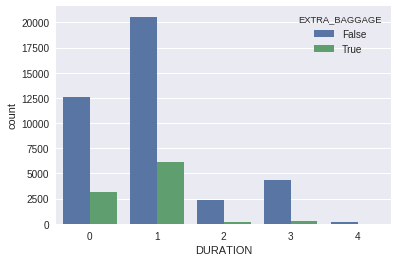

In [18]:
sns.countplot(x="DURATION", hue="EXTRA_BAGGAGE", data=data)

plt.show()

In [14]:
data.shape

(49867, 22)

In [15]:
print(data.isnull().sum())

TIMESTAMP           0
WEBSITE             0
GDS                 0
DEPARTURE           0
ARRIVAL             0
ADULTS              0
CHILDREN            0
INFANTS             0
TRAIN               0
HAUL_TYPE           0
DISTANCE            0
DEVICE              0
TRIP_TYPE           0
PRODUCT             0
SMS                 0
EXTRA_BAGGAGE       0
NO_GDS              0
TRIP_DAYS           0
PLANNING_DAYS       0
WEEKEND_DAYS        0
DURATION            0
CUSTOM_TRIP_TYPE    0
dtype: int64


In [16]:
# Store 'new_vars' dataset into new .csv file
data.to_csv('cleaned_enriched2_train.csv', index=False, sep=';')

In [ ]:
def plot_correlation_heatmap(data):
    # Compute the correlation matrix
    corr = data.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.show()

In [ ]:
plot_correlation_heatmap(data.drop('EXTRA_BAGGAGE', 1))